In [1]:
import os

CWD = os.getcwd()

DATA_DIR = f"{CWD}/data"
TRAIN_DIR = f"{DATA_DIR}/Train"
VAL_DIR = f"{DATA_DIR}/Val"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Concatenate, Input
import keras.preprocessing
import utils
import random
import numpy as np

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading and processing data

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator()
test_dataset = keras.preprocessing.image.ImageDataGenerator()

In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128,128), # scale to 128x128
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 288 images belonging to 2 classes.


In [5]:
val_generator = test_dataset.flow_from_directory(
    VAL_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle = False
)

Found 60 images belonging to 2 classes.


## Baseline CNN

<a href="https://ibb.co/Pjcx7RL"><img src="https://i.ibb.co/MScnYbv/Screenshot-2023-05-04-at-21-58-30.png" alt="Screenshot-2023-05-04-at-21-58-30" border="0"></a>

In [6]:
baseline_model = Sequential([
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten(),
    Dense(10),
    Dense(2, activation = "softmax")
])

baseline_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

Metal device set to: Apple M1


In [7]:
baseline_hist = baseline_model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 2,
    verbose = 0
)

In [8]:
val_pred_probs = baseline_model.predict(val_generator)
val_pred_labels = np.argmax(val_pred_probs, axis = 1)
val_true_labels = val_generator.classes

utils.evaluate_custom(val_true_labels, val_pred_labels)

2/2 [==============================] - 1s 237ms/step
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
f-1 score: 0.97
TNR: 0.97


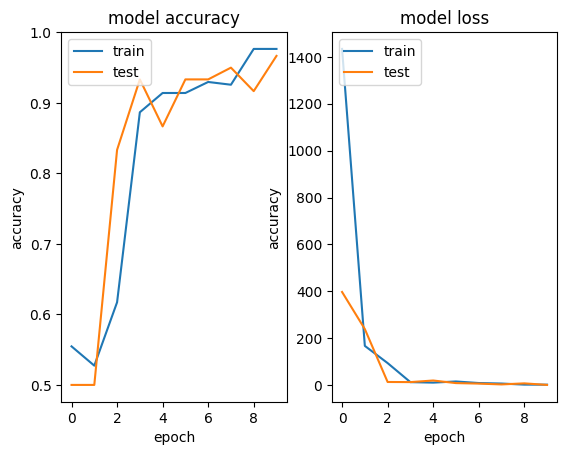

In [9]:
utils.plot_model_custom(baseline_model, "baseline_model")
utils.visualize_history(baseline_hist, name = "baseline")

## Prepare topological features

According to the paper we calculate 0-dimensional persistence diagram of the lower-star filtartion.

In [10]:
from ripser import Rips
import ripser
from persim import plot_diagrams
from gtda.diagrams import BettiCurve
import math

rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [11]:
batch_images_train, batch_labels_train = [], []

for _ in range(math.ceil(train_generator.samples / train_generator.batch_size)):
    data, label = train_generator.next()
    batch_images_train.extend(data)
    batch_labels_train.extend(label)

batch_images_test, batch_labels_test = [], []

for _ in range(math.ceil(val_generator.samples / val_generator.batch_size)):
    data, label = val_generator.next()
    batch_images_test.extend(data)
    batch_labels_test.extend(label)

batch_images_train = np.array(batch_images_train)
batch_labels_train = np.array(batch_labels_train)

batch_images_test = np.array(batch_images_test)
batch_labels_test = np.array(batch_labels_test)

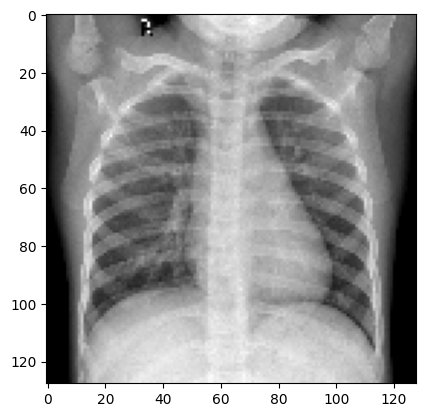

In [12]:
# The flow_from_directory method with color_mode='grayscale' returns a 3D array
vectorized_images = np.array(
    batch_images_train[:len(batch_images_train)]
    ).reshape(-1, 128, 128) / 255.0

plt.imshow(vectorized_images[0], cmap='gray')
plt.show()

In [13]:
dgms = [ripser.lower_star_img(-img) for img in vectorized_images]

Preview of an example persistence diagram.

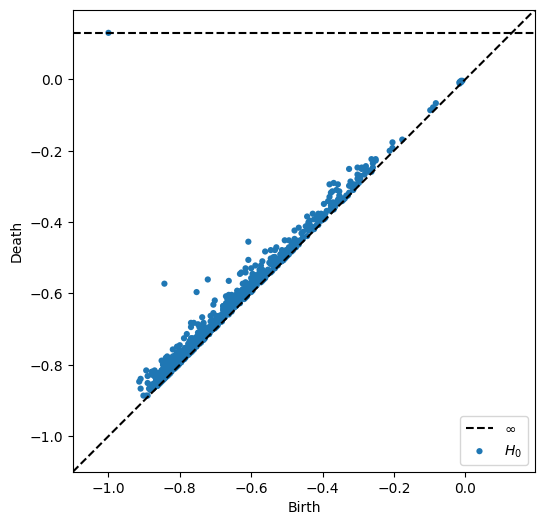

In [14]:
plt.figure(figsize=(6, 6))
plot_diagrams(dgms[11], lifetime=False)
plt.show()

I remove homologies that never die ($death \rightarrow inf$). Without that I can not calculate betti-curve as it needs to calculate $y = y * step$.

In [15]:
# change a format to fit into package that calculates betti-curve

dgms_processed = [
    [[(pt[0], pt[1], 0) for pt in dgm[:-1]]]
    for dgm in dgms
]

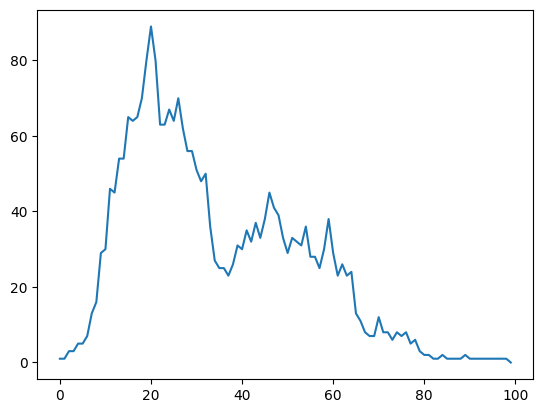

In [16]:
bc = BettiCurve() # n_bins is 100 by default

betti_curves = np.array([
    bc.fit_transform(X = dgm)[0][0]
    for dgm in dgms_processed
])

plt.plot(betti_curves[10]) # random example betti-curve
plt.show()

Above code after development was transformed into a single function to easily use it later on.

In [17]:
X_train_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_train)
y_train_1st_tda_net = batch_labels_train

X_test_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_test)
y_test_1st_tda_net = batch_labels_test

In [18]:
y_train_1st_tda_net.shape

(288, 2)

## 1st TDA-Net model

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6XvP1t5/Screenshot-2023-05-04-at-20-46-07.png" alt="Screenshot-2023-05-04-at-20-46-07" border="0"></a>

In [19]:
first_tda_net_model = Sequential([
    Dense(300),
    Dense(600),
    Dense(200),
    Dense(200),
    Dense(2, activation = "softmax")
])

first_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

first_tda_net_hist = first_tda_net_model.fit(
    x = X_train_1st_tda_net,
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 15,
    validation_data = (
        X_test_1st_tda_net,
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
)

In [20]:
val_pred_probs = first_tda_net_model.predict(X_test_1st_tda_net)
val_pred_labels = np.argmax(val_pred_probs, axis = 1)

# flatten output from softmax to logistic
val_true_labels = np.nonzero(np.array(y_test_1st_tda_net))[1]
utils.evaluate_custom(val_true_labels, val_pred_labels)

2/2 [==============================] - 0s 72ms/step
Accuracy: 0.85
Precision: 0.82
Recall: 0.9
f-1 score: 0.86
TNR: 0.8


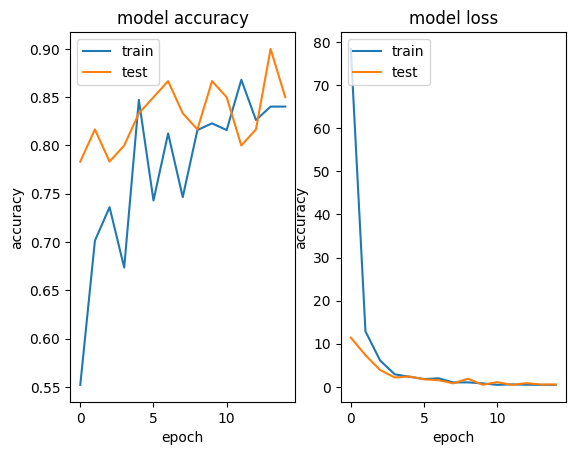

In [21]:
utils.plot_model_custom(first_tda_net_model, "first_tda_net")
utils.visualize_history(first_tda_net_hist, name = "first_tda_net")

## 2nd TDA-Net model

<a href="https://imgbb.com/"><img src="https://i.ibb.co/m4NSfFw/Screenshot-2023-05-05-at-23-26-13.png" alt="Screenshot-2023-05-05-at-23-26-13" border="0"></a>

In [22]:
second_tda_net_deep_stream = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten()
], name = "deep_stream")

second_tda_net_topological_stream = Sequential([
    Input(shape=(100,)),
    Dense(200),
    Dense(200),
    Dense(100),
], name = "topological_stream")

# I need to switch to the functional API for a final model
# as Sequential only supports single input

concatenated_outputs = Concatenate()([second_tda_net_deep_stream.output,
                                      second_tda_net_topological_stream.output])


dense_layer = Dense(10)(concatenated_outputs)

final_output = Dense(2, activation = "softmax")(dense_layer)

model_inputs = [second_tda_net_deep_stream.input,
                second_tda_net_topological_stream.input]

model_outputs = [final_output]

second_tda_net_model = Model(
    inputs = model_inputs,
    outputs = model_outputs)

second_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"]
)

second_tda_net_hist = second_tda_net_model.fit(
    x = [batch_images_train, X_train_1st_tda_net],
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 8,
    validation_data = (
        [batch_images_test, X_test_1st_tda_net],
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
)

In [23]:
val_pred_probs = second_tda_net_model.predict([batch_images_test, X_test_1st_tda_net])
val_pred_labels = np.argmax(val_pred_probs, axis = 1)

# flatten output from softmax to logistic
val_true_labels = np.nonzero(np.array(y_test_1st_tda_net))[1]
utils.evaluate_custom(val_true_labels, val_pred_labels)

2/2 [==============================] - 0s 68ms/step
Accuracy: 0.9
Precision: 0.88
Recall: 0.93
f-1 score: 0.9
TNR: 0.87


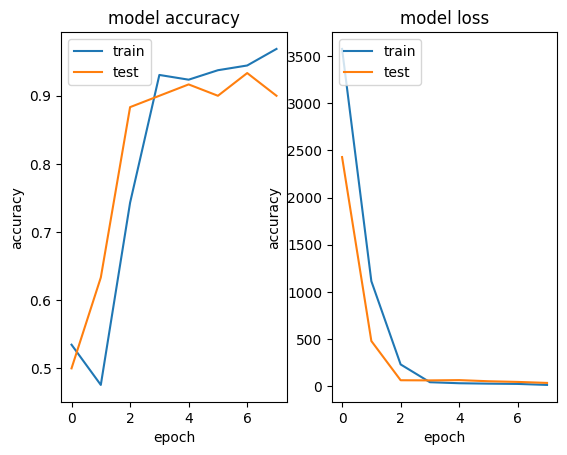

In [24]:
utils.plot_model_custom(second_tda_net_model, "second_tda_net_model")
utils.visualize_history(second_tda_net_hist, name = "second_tda_net")

## 3rd TDA-Net model

In [25]:
concatenated_outputs_3rd_model = Concatenate()([second_tda_net_deep_stream.output,
                                      second_tda_net_topological_stream.output,
                                      second_tda_net_topological_stream.input])


dense_layer = Dense(10)(concatenated_outputs_3rd_model)

final_output = Dense(2, activation = "softmax")(dense_layer)

model_inputs = [second_tda_net_deep_stream.input,
                second_tda_net_topological_stream.input]

model_outputs = [final_output]

third_tda_net_model = Model(
    inputs = model_inputs,
    outputs = model_outputs)

third_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"]
)

third_tda_net_model_hist = third_tda_net_model.fit(
    x = [batch_images_train, X_train_1st_tda_net],
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 8,
    validation_data = (
        [batch_images_test, X_test_1st_tda_net],
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
)

In [26]:
val_pred_probs = third_tda_net_model.predict([batch_images_test, X_test_1st_tda_net])
val_pred_labels = np.argmax(val_pred_probs, axis = 1)

# flatten output from softmax to logistic
val_true_labels = np.nonzero(np.array(y_test_1st_tda_net))[1]
utils.evaluate_custom(val_true_labels, val_pred_labels)

2/2 [==============================] - 0s 71ms/step
Accuracy: 0.97
Precision: 1.0
Recall: 0.93
f-1 score: 0.97
TNR: 1.0


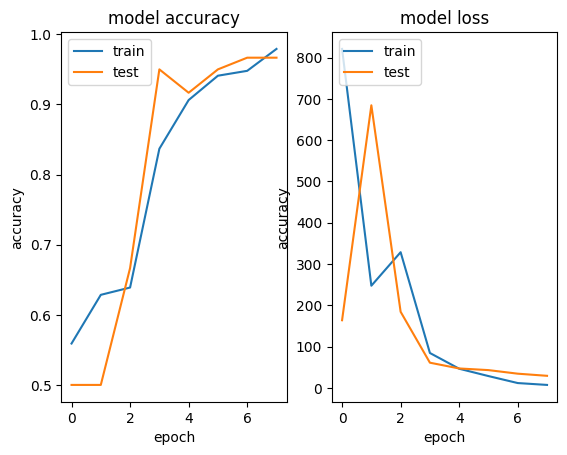

In [27]:
utils.plot_model_custom(third_tda_net_model, "third_tda_net_model")
utils.visualize_history(third_tda_net_model_hist, name = "third_tda_net")

## Results

|           | Base model | $TDA-Net_{1}$ | $TDA-Net_{1,2}$ | $TDA-Net_{1,2,3}$ |
|-----------|------------|---------------|-----------------|-------------------|
| Accuracy  | 0.97       | 0.85          | 0.90            | 0.97              |
| Precision | 0.97       | 0.82          | 0.88            | 1.0               |
| Recall    | 0.97       | 0.90          | 0.93            | 0.93              |
| f-1 score | 0.97       | 0.86          | 0.90            | 0.97              |
| TNR       | 0.97       | 0.8           | 0.87            | 1.0               |